# Carousel Bandits Deezer Experiment


Motivación: El objetivo del modelo es predecir la probabilidad de que un usuario interactúe (escuche o "haga stream") con una playlist en particular [1].

Para ello, se aplican diversas técnicas de aprendizaje de representaciones mediante vectores de embedding, los cuales resumen las preferencias musicales de los usuarios en un espacio latente de 96 dimensiones, garantizando la anonimización de los datos. Además, se emplea un modelo de multi-armed bandit que incluye enfoques como cascade-based updates y delayed batch feedback, ajustando dinámicamente las recomendaciones de playlists en función del contexto del usuario. El modelo calcula el producto interno entre el vector de embedding de cada usuario y un vector de pesos asociado a cada playlist, y luego aplica una función sigmoide para transformar este valor en una probabilidad entre 0 y 1 [1].

Asimismo, se implementa una estrategia de semi-personalización en la que los usuarios son agrupados en segmentos mediante un algoritmo de clustering k-means (K = 100), permitiendo equilibrar la personalización individual con una aproximación más generalizada para grupos de usuarios con características similares [1].

Referencias:

[1] deezer/carousel_bandits: Source code and data from the RecSys 2020 article “Carousel Personalization in Music Streaming Apps with Contextual Bandits” by W. Bendada, G. Salha and T. Bontempelli. (n.d.). GitHub. https://github.com/deezer/carousel_bandits


# Librerias

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from scipy.special import expit
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import defaultdict
from math import log

# Exploración del Dataset

In [2]:
dataset_playlist = pd.read_csv("playlist_features.csv")
dataset_playlist.head()

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_87,dim_88,dim_89,dim_90,dim_91,dim_92,dim_93,dim_94,dim_95,96
0,0.024252,-0.018636,0.012410,0.001008,0.044494,-0.004434,-0.005695,0.016350,0.019771,0.009652,...,0.013161,0.016955,0.005556,0.032493,0.023227,0.002972,0.012221,0.016389,-0.004321,-5.212592
1,-0.002291,-0.003837,0.027045,0.003238,0.027638,0.016666,-0.000113,-0.008341,0.026533,0.013764,...,0.012942,0.022978,-0.009120,0.002435,-0.000940,-0.020064,-0.020775,-0.003955,0.013123,-5.257495
2,0.009996,0.001475,0.016315,0.035247,0.014389,0.018869,0.005860,0.003982,-0.007220,0.017888,...,0.022230,0.036029,0.002565,0.020917,-0.008665,0.019002,-0.023298,0.049232,0.006402,-5.599810
3,0.001324,0.011623,0.007804,0.009014,0.006430,0.002558,0.008000,0.009254,0.003991,0.011995,...,0.009921,0.002054,0.006869,-0.004186,0.008501,0.006809,0.007393,0.003085,0.009104,-5.945421
4,-0.001324,0.015705,0.004648,0.005653,-0.003159,0.001712,0.021995,-0.013604,0.002715,0.003533,...,0.009651,0.005125,-0.002147,-0.005928,0.003602,0.003586,0.025799,0.015432,-0.003963,-6.525579


El conjunto de datos playlist_features.csv contiene 862 playlists. Cada playlist i está representada por un vector de pesos de 97 dimensiones, que describe sus características. Este vector se utiliza para calcular la probabilidad de que un usuario interactúe con esa playlist. Las dimensiones del vector pueden representar diversas características, como el ID de las canciones, el género de las canciones, entre otros aspectos, todos ellos anonimizados por razones de privacidad. Además, la última característica del vector, correspondiente a la dimensión 96, representa un término de sesgo que puede ser útil para el posterior entrenamiento del modelo [1].


In [3]:
dataset_user = pd.read_csv("user_features_small.csv")
dataset_user.head()

,segment,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,...,dim_86,dim_87,dim_88,dim_89,dim_90,dim_91,dim_92,dim_93,dim_94,dim_95
0,0,0.238895,1.559068,-1.492596,1.041009,2.040157,-2.914569,-0.743588,1.996449,-0.917277,...,-0.652371,-0.539649,0.189309,1.241029,0.767918,0.619496,4.004763,1.312571,-0.441051,0.898858
1,0,-0.268669,0.617194,-0.742123,1.677183,1.369093,-1.761860,-1.237178,1.276799,-2.924475,...,-0.060747,-1.312460,1.352925,1.251065,-1.624764,1.314707,2.027448,0.988371,-0.314620,1.583408
2,0,0.730793,1.615805,-0.540211,1.519919,0.474167,-2.616138,-1.168033,0.935113,-1.695110,...,-0.041504,0.456923,0.249240,0.878546,-0.787824,0.495024,1.752296,0.536689,-0.106732,0.516656
3,0,1.739003,1.546201,0.756946,2.240684,0.636115,-2.327271,-0.684070,1.323303,-3.234894,...,-1.372924,-1.172656,0.859095,1.026131,-0.410318,0.017065,-0.019434,0.003572,-0.638508,0.527119
4,0,0.060900,1.313942,-0.725372,0.953238,1.338075,-2.561447,-0.384696,1.040172,-1.201964,...,-0.920380,-0.417005,0.705332,0.741709,-1.598617,0.882672,2.023240,0.971578,-0.329573,0.629994


El conjunto de datos incluye 974,960 usuarios de Deezer completamente anonimizados, para este experimento utilizaremos la versión small que contiene 10 usuarios pertenecientes al mismo segmento. Cada usuario se describe mediante [1]:

Un vector de embedding de 96 dimensiones (campos dim_0 a dim_95), al cual se le añade un término de sesgo en nuestro código, que resume las preferencias musicales del usuario [1].

Además, hay una columna denominada "segment" que representa el identificador del grupo al que pertenece cada usuario dentro de los clusters, con k=100 [1].

# Experimentación para 3 modelos detallados en el paper

Modelos: RandomPolicy, KLUCBSegmentPolicy y EpsilonGreedySegmentPolicy

**El codigo fue extraido de: https://github.com/deezer/carousel_bandits**

In [4]:
sns.set_style(style='darkgrid')

In [5]:
playlist_features = np.array(dataset_playlist)

In [6]:
n_playlist = playlist_features.shape[0]
n_rounds = 100

In [7]:
n_users = len(dataset_user)

In [8]:
user_features = np.array(dataset_user.drop(["segment"], axis=1))
user_features = np.concatenate([user_features, np.ones((n_users, 1))], axis=1)
user_segment = np.array(dataset_user.segment)

In [9]:
# This class uses user and playlist features datasets to simulate users responses to a list of recommendations
class ContextualEnvironment():
    def __init__(self, user_features, playlist_features, user_segment, n_recos):
        self.user_features = user_features
        self.playlist_features = playlist_features
        self.user_segment = user_segment
        self.n_recos = n_recos
        self.th_segment_rewards = np.zeros(user_features.shape[0])
        self.th_rewards = np.zeros(user_features.shape[0])
        self.compute_optimal_theoretical_rewards()
        self.compute_segment_optimal_theoretical_rewards()

    # Computes expected reward for each user given their recommendations
    def compute_theoretical_rewards(self, batch_user_ids, batch_recos):
        batch_user_features = np.take(self.user_features, batch_user_ids, axis = 0)
        batch_playlist_features = np.take(self.playlist_features, batch_recos, axis = 0)
        n_users = len(batch_user_ids)
        th_reward = np.zeros(n_users)
        for i in range(n_users):
            probas = expit(batch_user_features[i].dot(batch_playlist_features[i].T))
            th_reward[i] = 1 - reduce(lambda x,y : x * y, 1 - probas)
        return th_reward

    # Computes list of n recommendations with highest expected reward for each user
    def compute_optimal_recos(self, batch_user_ids, n):
        batch_user_features = np.take(self.user_features, batch_user_ids, axis = 0)
        n_users = len(batch_user_ids)
        probas = batch_user_features.dot(self.playlist_features.T)
        optim = np.argsort(-probas)[:, :n]
        return optim

    # Computes highest expected reward for each user
    def compute_optimal_theoretical_rewards(self):
        n_users = self.user_features.shape[0]
        u = 0
        step = 100000
        while u < n_users:
            users_ids = range(u, min(n_users, u + step))
            opt_recos = self.compute_optimal_recos(users_ids, self.n_recos)
            opt_rewards = self.compute_theoretical_rewards(users_ids, opt_recos)
            self.th_rewards[u:min(n_users, u + step)] = opt_rewards
            u += step
        return

    # Computes list of n recommendations with highest expected reward for each segment
    def compute_segment_optimal_recos(self, n):
        n_segments = len(np.unique(self.user_segment))
        segment_recos = np.zeros((n_segments, n), dtype = np.int64)
        for i in range(n_segments):
            mean_probas = np.mean(expit(np.take(self.user_features, np.where(self.user_segment == i)[0], axis = 0).dot(self.playlist_features.T)), axis = 0)
            reward = 1 - reduce(lambda x,y : x * y, 1 + np.sort(-mean_probas)[:n])
            segment_recos[i] = np.argsort(-mean_probas)[:n]
        return segment_recos

    # Computes highest expected reward for each segment
    def compute_segment_optimal_theoretical_rewards(self):
        n_users = self.user_features.shape[0]
        u = 0
        step = 100000
        segment_recos = self.compute_segment_optimal_recos(self.n_recos)
        while u < n_users:
            users_ids = range(u, min(n_users, u+ step))
            user_segment = np.take(self.user_segment, users_ids)
            opt_recos = np.take(segment_recos, user_segment, axis = 0)
            opt_rewards = self.compute_theoretical_rewards(users_ids, opt_recos)
            self.th_segment_rewards[u:min(n_users, u+ step)] = opt_rewards
            u += step
        return

    # Given a list of users and their respective list of recos (each of size self.n_recos), computes
    # corresponding simulated reward
    def simulate_batch_users_reward(self, batch_user_ids, batch_recos):

        # First, compute probability of streaming each reco and draw rewards accordingly
        batch_user_features = np.take(self.user_features, batch_user_ids, axis = 0)
        batch_playlist_features = np.take(self.playlist_features, batch_recos, axis = 0)
        n_users = len(batch_user_ids)
        n = len(batch_recos[0])
        probas = np.zeros((n_users, n))
        for i in range(n_users):
            probas[i] = expit(batch_user_features[i].dot(batch_playlist_features[i].T)) # probability to stream each reco
        rewards = np.zeros((n_users, n))
        i = 0
        rewards_uncascaded = np.random.binomial(1, probas) # drawing rewards from probabilities
        positive_rewards = set()

        # Then, for each user, positive rewards after the first one are set to 0 (and playlists as "unseen" subsequently)
        # to imitate a cascading browsing behavior
        # (nonetheless, users can be drawn several times in the batch of a same round ; therefore, each user
        # can have several positive rewards - i.e. stream several playlists - in a same round, consistently with
        # the multiple-plays framework from the paper)
        nz = rewards_uncascaded.nonzero()
        for i in range(len(nz[0])):
            if nz[0][i] not in positive_rewards:
                rewards[nz[0][i]][nz[1][i]] = 1
                positive_rewards.add(nz[0][i])
        return rewards


In [10]:
from scipy.optimize import minimize
import numpy as np


# Disclaimer: this class is taken from:
# https://gdmarmerola.github.io/ts-for-contextual-bandits/


# Defining a class for Online Bayesian Logistic Regression
class OnlineLogisticRegression:

    # Initializing
    def __init__(self, lambda_, alpha, n_dim, bias, maxiter = 15):

        # Hyperparameter: deviation on the prior (L2 regularizer)
        self.lambda_ = lambda_; self.alpha = alpha; self.maxiter = maxiter

        # Initializing parameters of the model
        self.n_dim = n_dim
        # m: mean of the Bi, q inverse variance of the distribution
        self.m = np.zeros(self.n_dim)
        self.m[-1] = bias
        self.q = np.ones(self.n_dim) * self.lambda_

        # Initializing weights
        self.w = np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)

    # Loss function
    def loss(self, w, *args):
        X, y = args
        # Note: the bias is removed from the "regularization term" of the loss
        return 0.5 * (self.q[:-1] * (w[:-1] - self.m[:-1])).dot(w[:-1] - self.m[:-1]) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])

    # Gradient
    def grad(self, w, *args):
        X, y = args
        return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)

    # Fitting method
    def fit(self, X, y):

        # Step 1, find w
        self.w = minimize(self.loss, self.w, args = (X, y), jac = self.grad, method = "L-BFGS-B", options = {'maxiter': self.maxiter}).x
        self.m = self.w

        # Step 2, update q
        P = (1 + np.exp(1 - X.dot(self.m))) ** (-1)
        self.q = self.q + (P*(1-P)).dot(X ** 2)

In [17]:
# Abstract class defining the minimal functions that need
# to be implemented to create new bandit policy classes

class Policy:

    # Returns a list of size n_recos of playlist ids
    def recommend_to_users_batch(self, batch_users, n_recos=12):
        return

    # Updates policies parameters
    def update_policy(self, user_ids, recos , rewards):
        return


# A simple baseline that randomly recommends n_recos playlists to each user.
class RandomPolicy(Policy):
    def __init__(self, n_playlists, cascade_model=True):
        self.cascade_model = cascade_model
        self.n_playlists = n_playlists

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        n_users = len(batch_users)
        recos = np.zeros((n_users, n_recos), dtype=np.int64)
        r = np.arange(self.n_playlists)
        for i in range(n_users):
            np.random.shuffle(r)
            recos[i] = r[:n_recos]
        return recos

    def update_policy(self, user_ids, recos, rewards, l_init=3):
        return


#  Upper Confidence Bound (UCB) strategy, using KL-UCB bounds [Garivier and Cappe, 2011] tailored for Bernoulli rewards
class KLUCBSegmentPolicy(Policy):
    def __init__(self, user_segment, n_playlists, precision = 1e-6, eps = 1e-15, cascade_model=True):
        self.user_segment = user_segment
        n_segments = len(np.unique(self.user_segment))
        self.playlist_display = np.zeros((n_segments, n_playlists))
        self.playlist_success = np.zeros((n_segments, n_playlists))
        self.playlist_score = np.ones((n_segments, n_playlists))
        self.t = 0
        self.cascade_model = cascade_model
        self.precision = precision
        self.eps = eps

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        user_segment = np.take(self.user_segment, batch_users)
        user_score = np.take(self.playlist_score, user_segment, axis = 0)
        # Break ties
        user_random_score = np.random.random(user_score.shape)
        user_choice = np.lexsort((user_random_score, -user_score))[:, :n_recos]
        # Shuffle l_init first slots
        np.random.shuffle(user_choice[0:l_init])
        return user_choice

    def kl(self, x, y):
        x = min(max(x, self.eps), 1 - self.eps)
        y = min(max(y, self.eps), 1 - self.eps)
        return x * log(x / y) + (1 - x) * log((1 - x) / (1 - y))

    def scoring_function(self, n_success, n, t):
        if n == 0:
            return 1.0
        p = n_success / n
        value = p
        u = 1
        threshold = log(t) / n
        _count_iteration = 0
        while _count_iteration < 50 and u - value > self.precision:
            _count_iteration += 1
            m = (value + u) * 0.5
            if self.kl(p, m) > threshold:
                u = m
            else:
                value = m
        return (value + u) * 0.5

    def update_policy(self, user_ids, recos, rewards, l_init=3):
        batch_size = len(user_ids)
        modified_data = defaultdict(set)
        for i in range(batch_size):
            user_segment = self.user_segment[user_ids[i]]
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display +=1
                modified_data[user_segment].add(p)
                self.playlist_success[user_segment][p]+=r
                self.playlist_display[user_segment][p]+=1
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        self.t = self.playlist_display.sum()
        for seg,pls in modified_data.items():
            for pl in pls:
                self.playlist_score[seg][pl] = self.scoring_function(self.playlist_success[seg][pl], self.playlist_display[seg][pl], self.t)
        return


# An Explore-then-Commit strategy: similar to random until each playlist has been displayed n times or more,
# then recommends the top n_reco playlists with highest mean observed rewards, for each segment
class ExploreThenCommitSegmentPolicy(Policy):
    def __init__(self, user_segment, n_playlists, min_n, cascade_model=True):
        self.user_segment = user_segment
        n_segments = len(np.unique(self.user_segment))
        self.playlist_display = np.zeros((n_segments, n_playlists))
        self.playlist_success = np.zeros((n_segments, n_playlists))
        self.min_n = min_n
        self.cascade_model = cascade_model

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        user_segment = np.take(self.user_segment, batch_users)
        user_success = np.take(self.playlist_success, user_segment, axis = 0)
        user_displays = np.take(self.playlist_display, user_segment, axis = 0).astype(float)
        user_random_score = np.random.random(user_displays.shape)
        user_score = np.divide(user_success, user_displays, out=np.zeros_like(user_displays), where=user_displays!=0)
        discounted_displays = np.maximum(np.zeros_like(user_displays), self.min_n - user_displays)
        user_choice = np.lexsort((user_random_score, - user_score, -discounted_displays))[:, :n_recos]
        # Shuffle l_init first slots
        np.random.shuffle(user_choice[0:l_init])
        return user_choice

    def update_policy(self, user_ids, recos , rewards, l_init=3):
        batch_size = len(user_ids)
        for i in range(batch_size):
            user_segment = self.user_segment[user_ids[i]]
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display +=1
                self.playlist_success[user_segment][p]+=r
                self.playlist_display[user_segment][p]+=1
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        return


# Segment-based Epsilon-Greedy strategy: recommends playlists randomly with probability epsilon,
# otherwise recommends the top n_recos with highest mean observed rewards.
class EpsilonGreedySegmentPolicy(Policy):
    def __init__(self, user_segment, n_playlists, epsilon, cascade_model=True):
        self.user_segment = user_segment
        n_segments = len(np.unique(self.user_segment))
        self.playlist_display = np.zeros((n_segments, n_playlists))
        self.playlist_success = np.zeros((n_segments, n_playlists))
        self.playlist_score = np.ones((n_segments, n_playlists))
        self.epsilon = epsilon
        self.cascade_model = cascade_model

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        user_segment = np.take(self.user_segment, batch_users)
        user_scores = np.take(self.playlist_score, user_segment, axis = 0)
        user_random_score = np.random.random(user_scores.shape)
        n_users = len(batch_users)
        user_greedy = np.random.binomial(1, [1- self.epsilon for i in range(n_users)])
        new_scores = user_scores * user_greedy[:,np.newaxis]
        user_choice = np.lexsort((user_random_score, -new_scores))[:, :n_recos]
        # Shuffle l_init first slots
        np.random.shuffle(user_choice[0:l_init])
        return user_choice

    def update_policy(self, user_ids, recos, rewards, l_init=3):
        batch_size = len(user_ids)
        for i in range(batch_size):
            user_segment = self.user_segment[user_ids[i]]
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display +=1
                self.playlist_success[user_segment][p]+=r
                self.playlist_display[user_segment][p]+=1
                self.playlist_score[user_segment][p] = self.playlist_success[user_segment][p] / self.playlist_display[user_segment][p]
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        return


# Segment-based Thompson Sampling strategy, with Beta(alpha_zero,beta_zero) priors
class TSSegmentPolicy(Policy):
    def __init__(self, user_segment, n_playlists, alpha_zero=1, beta_zero=99, cascade_model=True):
        self.user_segment = user_segment
        n_segments = len(np.unique(self.user_segment))
        self.playlist_display = np.zeros((n_segments, n_playlists))
        self.playlist_success = np.zeros((n_segments, n_playlists))
        self.alpha_zero = alpha_zero
        self.beta_zero = beta_zero
        self.t = 0
        self.cascade_model = cascade_model

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        user_segment = np.take(self.user_segment, batch_users)
        user_displays = np.take(self.playlist_display, user_segment, axis = 0).astype(float)
        user_success = np.take(self.playlist_success, user_segment, axis = 0)
        user_score = np.random.beta(self.alpha_zero+user_success, self.beta_zero+user_displays - user_success)
        user_choice = np.argsort(-user_score)[:, :n_recos]
        # Shuffle l_init first slots
        np.random.shuffle(user_choice[0:l_init])
        return user_choice

    def update_policy(self, user_ids, recos , rewards, l_init = 3):
        batch_size = len(user_ids)
        for i in range(batch_size):
            user_segment = self.user_segment[user_ids[i]]
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display +=1
                self.playlist_success[user_segment][p]+=r
                self.playlist_display[user_segment][p]+=1
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        return


# Linear Thompson Sampling strategy for fully personalized contextual bandits, as in [Chapelle and Li, 2011]
class LinearTSPolicy(Policy):
    def __init__(self, user_features, n_playlists, bias=0.0, cascade_model=True):
        self.user_features = user_features
        n_dim = user_features.shape[1]
        self.n_playlists = n_playlists
        self.models = [OnlineLogisticRegression(1, 1, n_dim, bias, 15) for i in range(n_playlists)]
        self.m = np.zeros((n_playlists, n_dim))
        self.m[:, -1] = bias
        self.q = np.ones((n_playlists, n_dim))
        self.n_dim = n_dim
        self.cascade_model = cascade_model

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        user_features = np.take(self.user_features, batch_users, axis=0)
        n_users = len(batch_users)
        recos = np.zeros((n_users, n_recos), dtype=np.int64)
        step = 1
        u = 0
        while u < n_users:
            u_next = min(n_users, u+step)
            p_features_sampled =(np.random.normal(self.m, 1/np.sqrt(self.q), size= (u_next-u, self.n_playlists, self.n_dim)))
            step_p = p_features_sampled.dot(user_features[u:u_next].T)
            for i in range(u_next - u):
                recos[u+i] = np.argsort((-step_p[i,:,i]))[:n_recos]
            u += step
        # Shuffle l_init first slots
        np.random.shuffle(recos[0:l_init])
        return recos

    def update_policy(self, user_ids, recos , rewards, l_init=3):
        rewards = 2*rewards - 1
        batch_size = len(user_ids)
        modified_playlists ={}
        for i in range(batch_size):
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display +=1
                if p not in modified_playlists:
                    modified_playlists[p] = {"X" : [], "Y" : []}
                modified_playlists[p]["X"].append(self.user_features[user_ids[i]])
                modified_playlists[p]["Y"].append(r)
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        for p,v in modified_playlists.items():
            X = np.array(v["X"])
            Y = np.array(v["Y"])
            self.models[p].fit(X,Y)
            self.m[p] = self.models[p].m
            self.q[p] = self.models[p].q
        return

class MostPopularPolicy(Policy):
    def __init__(self, user_segment, n_playlists, cascade_model=True):
        self.user_segment = user_segment
        n_segments = len(np.unique(self.user_segment))  # Number of unique segments
        self.playlist_display = np.zeros((n_segments, n_playlists))  # Count of playlist displays
        self.playlist_success = np.zeros((n_segments, n_playlists))  # Count of successful plays
        self.n_playlists = n_playlists
        self.cascade_model = cascade_model

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        # Calculate popularity scores: based on success rate (success / display count)
        user_segment = np.take(self.user_segment, batch_users)
        scores = np.take(self.playlist_success, user_segment, axis=0) / np.take(self.playlist_display, user_segment, axis=0)
        # Break ties randomly
        random_scores = np.random.random(scores.shape)
        sorted_indices = np.lexsort((random_scores, -scores))
        # Return top n_recos playlists for each user
        recos = sorted_indices[:, :n_recos]
        # Shuffle l_init first slots
        for rec in recos:
            np.random.shuffle(rec[:l_init])
        return recos

    def update_policy(self, user_ids, recos, rewards, l_init=3):
        batch_size = len(user_ids)
        for i in range(batch_size):
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display += 1
                user_segment = self.user_segment[user_ids[i]]
                self.playlist_success[user_segment][p] += r
                self.playlist_display[user_segment][p] += 1
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        return


<ipython-input-17-1b8b9224ecf6>:280: RuntimeWarning: invalid value encountered in divide
  scores = np.take(self.playlist_success, user_segment, axis=0) / np.take(self.playlist_display, user_segment, axis=0)


Round: 1/100. Elapsed time: 0.550407 sec.
Cumulative regrets: 
	random : 5.240698978356841
	etc-seg-explore : 3.240698978356841
	kl-ucb-seg : 4.240698978356841
	etc-seg-exploit : 5.240698978356841
	epsilon-greedy-explore : 4.240698978356841
	epsilon-greedy-exploit : 5.240698978356841
	ts-seg-naive : 2.240698978356841
	ts-seg-pessimistic : 5.240698978356841
	ts-lin-naive : 4.240698978356841
	ts-lin-pessimistic : 4.240698978356841
	most-popular : 5.240698978356841 

Round: 10/100. Elapsed time: 6.102965 sec.
Cumulative regrets: 
	random : 43.33027970642109
	etc-seg-explore : 33.33027970642109
	kl-ucb-seg : 40.33027970642109
	etc-seg-exploit : 38.33027970642109
	epsilon-greedy-explore : 34.33027970642109
	epsilon-greedy-exploit : 36.33027970642109
	ts-seg-naive : 36.33027970642109
	ts-seg-pessimistic : 37.33027970642109
	ts-lin-naive : 37.33027970642109
	ts-lin-pessimistic : 40.33027970642109
	most-popular : 28.330279706421088 

Round: 20/100. Elapsed time: 10.393718 sec.
Cumulative regre

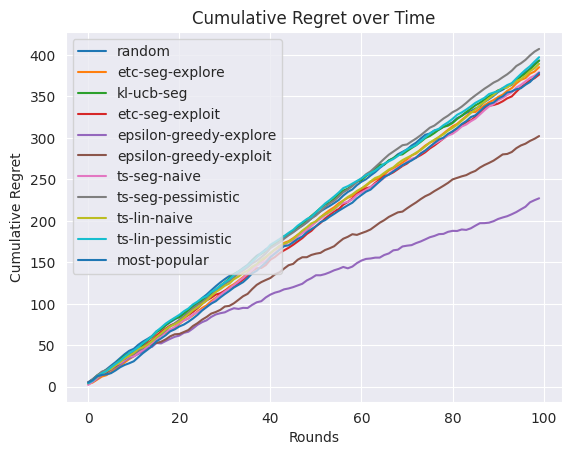

In [18]:
# Función para establecer las políticas
def set_policies(policies_name, user_segment, user_features, n_playlists):
    POLICIES_SETTINGS = {
        'random': RandomPolicy(n_playlists),
        'etc-seg-explore': ExploreThenCommitSegmentPolicy(user_segment, n_playlists, min_n=100, cascade_model=True),
        'kl-ucb-seg': KLUCBSegmentPolicy(user_segment, n_playlists, cascade_model=True),
        'etc-seg-exploit' : ExploreThenCommitSegmentPolicy(user_segment, n_playlists, min_n = 20, cascade_model = True),
        'epsilon-greedy-explore' : EpsilonGreedySegmentPolicy(user_segment, n_playlists, epsilon = 0.1, cascade_model = True),
        'epsilon-greedy-exploit' : EpsilonGreedySegmentPolicy(user_segment, n_playlists, epsilon = 0.01, cascade_model = True),
        'ts-seg-naive' : TSSegmentPolicy(user_segment, n_playlists, alpha_zero = 1, beta_zero = 1, cascade_model = True),
        'ts-seg-pessimistic' : TSSegmentPolicy(user_segment, n_playlists, alpha_zero = 1, beta_zero = 99, cascade_model = True),
        'ts-lin-naive' : LinearTSPolicy(user_features, n_playlists, bias = 0.0, cascade_model = True),
        'ts-lin-pessimistic' : LinearTSPolicy(user_features, n_playlists, bias = -5.0, cascade_model = True),
        'most-popular' : MostPopularPolicy(user_segment, n_playlists, cascade_model = True)
    }
    return [POLICIES_SETTINGS[name] for name in policies_name]

# Variables de configuración
# Variables de configuración
output_path = "results.json"
policies = "random,etc-seg-explore,kl-ucb-seg,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic,most-popular"
n_recos = 12
l_init = 3
n_users_per_round = 9
n_rounds = 100
print_every = 10

# Cargar datos

cont_env = ContextualEnvironment(user_features, playlist_features, user_segment, n_recos)

policies_name = policies.split(",")
policies = set_policies(policies_name, user_segment, user_features, n_playlist)
n_policies = len(policies)
overall_rewards = np.zeros((n_policies, n_rounds))
overall_optimal_reward = np.zeros(n_rounds)

# Simulaciones
start_time = time.time()
for i in range(n_rounds):
    user_ids = np.random.choice(range(n_users), n_users_per_round)
    overall_optimal_reward[i] = np.take(cont_env.th_rewards, user_ids).sum()
    for j in range(n_policies):
        recos = policies[j].recommend_to_users_batch(user_ids, n_recos, l_init)
        rewards = cont_env.simulate_batch_users_reward(batch_user_ids=user_ids, batch_recos=recos)
        policies[j].update_policy(user_ids, recos, rewards, l_init)
        overall_rewards[j, i] = rewards.sum()
    if i == 0 or (i + 1) % print_every == 0 or i + 1 == n_rounds:
        print("Round: %d/%d. Elapsed time: %f sec." % (i + 1, n_rounds, time.time() - start_time))
        print("Cumulative regrets: \n%s \n" % "\n".join(["	%s : %s" % (policies_name[j], str(np.sum(overall_optimal_reward - overall_rewards[j]))) for j in range(n_policies)]))

# Guardar resultados
print("Saving cumulative regrets in %s" % output_path)
cumulative_regrets = {policies_name[j]: list(np.cumsum(overall_optimal_reward - overall_rewards[j])) for j in range(n_policies)}
with open(output_path, 'w') as fp:
    json.dump(cumulative_regrets, fp)

# Graficar resultados
for j in range(n_policies):
    plt.plot(cumulative_regrets[policies_name[j]], label=policies_name[j])
plt.title('Cumulative Regret over Time')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.show()

Simulacion en dataset original con 9 usuarios

### Figura 1: Gráfico del cumulative regret extraído del paper "Carousel Personalization in Music Streaming Apps with Contextual Bandits" - RecSys 2020.

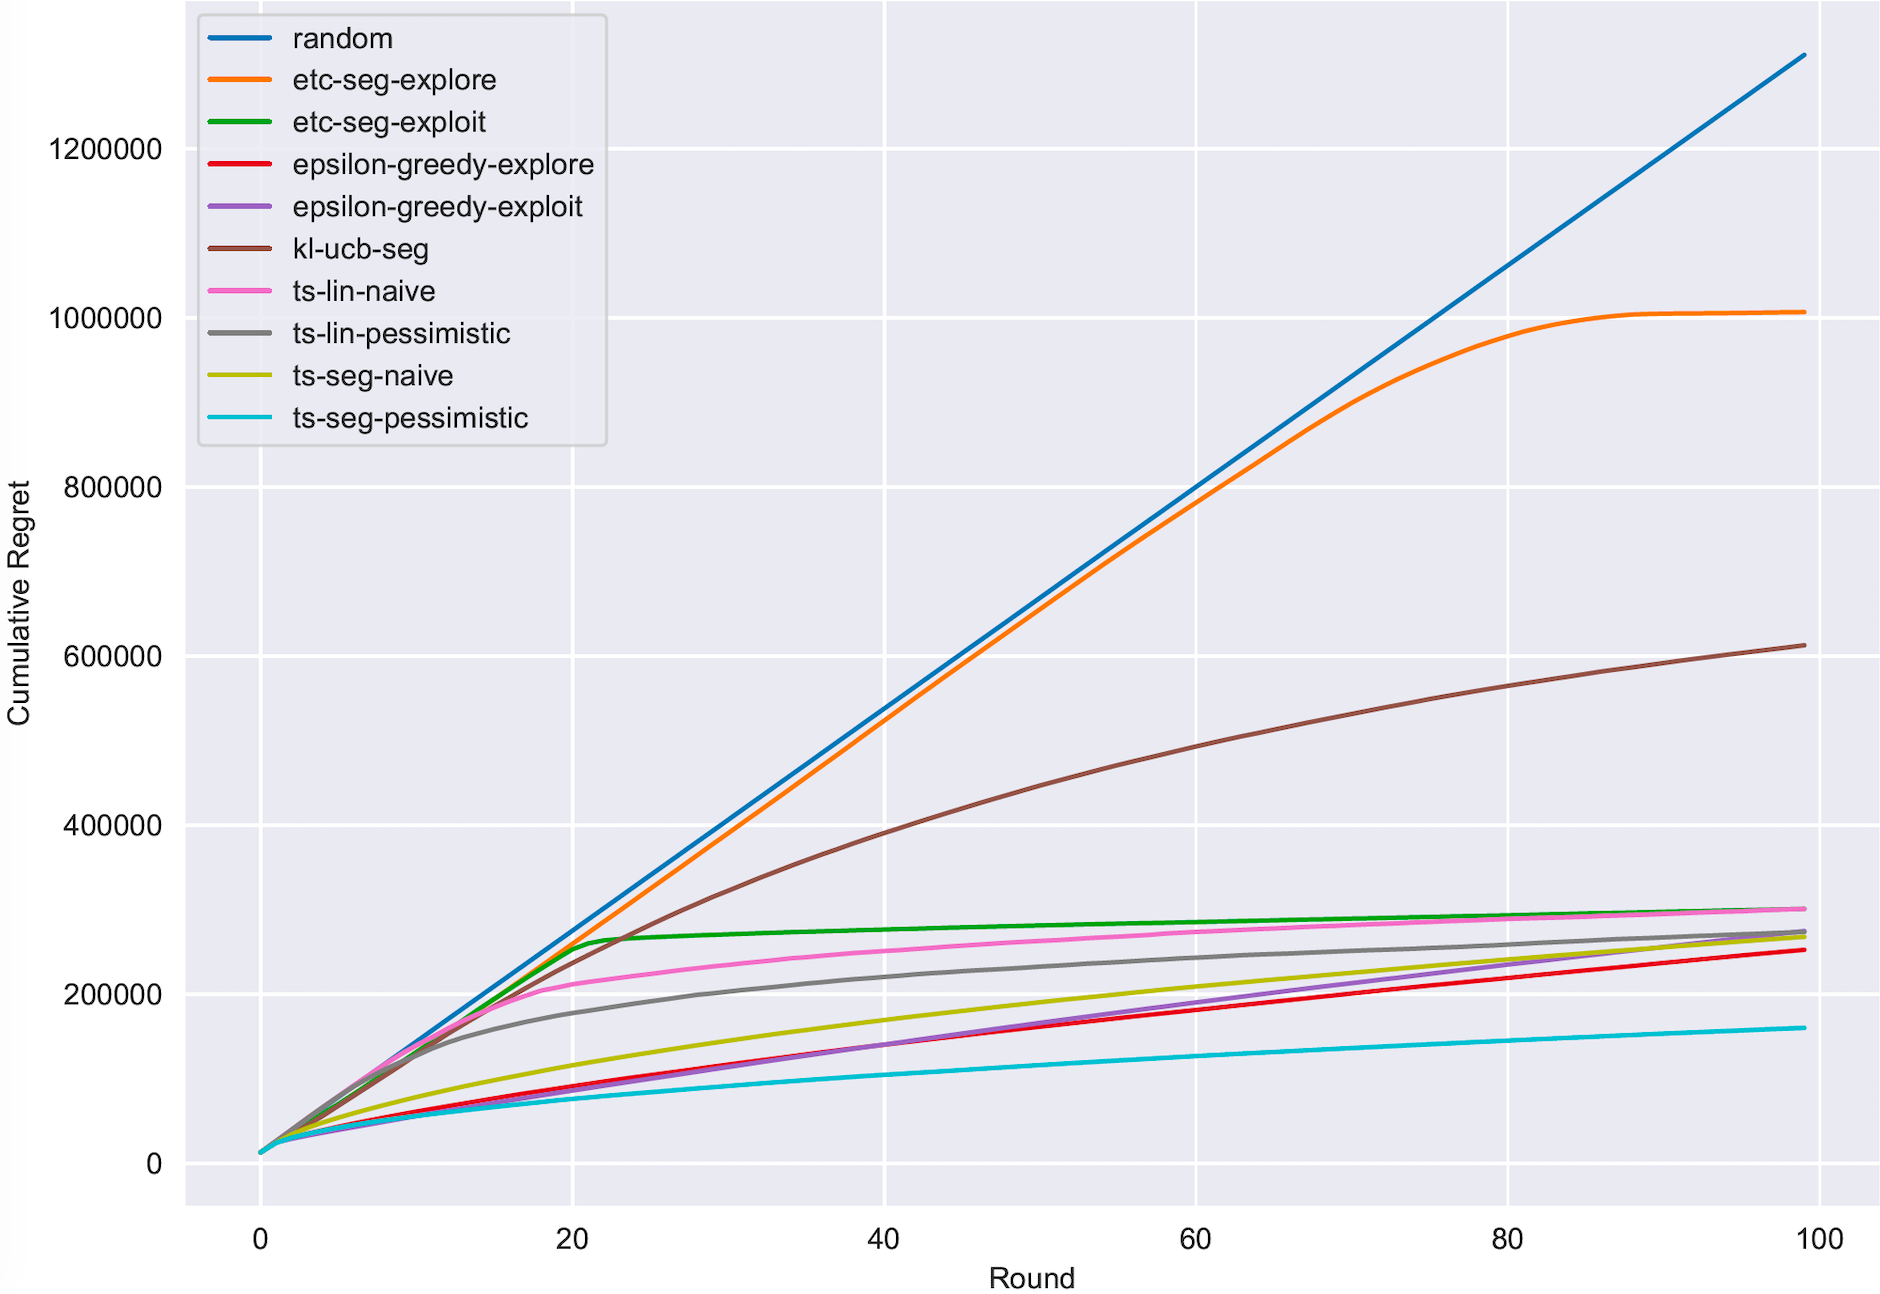